# Building a Model

### Installing requirements

In [2]:
from patchify import unpatchify

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

### UNET model architecture

In [ ]:
import keras.backend as K

class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result


def f1_metric(y_pred, y_true):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def IoU(y_pred, y_true):
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return tf.reduce_mean(I / U)

def unet(pretrained_weights=None, input_size=(512, 512, 3)):
		inputs = Input(input_size)
		conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
		conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
		pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
		conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
		conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
		pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
		conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
		conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
		pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
		conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
		conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
		drop4 = Dropout(0.5)(conv4)
		pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

		conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
		conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
		drop5 = Dropout(0.5)(conv5)

		up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5))
		merge6 = concatenate([drop4, up6], axis=3)
		conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
		conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

		up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
		merge7 = concatenate([conv3, up7], axis=3)
		conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
		conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

		up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
		merge8 = concatenate([conv2, up8], axis=3)
		conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
		conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

		up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
		merge9 = concatenate([conv1, up9], axis=3)
		conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
		conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
		conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
		conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

		model = Model(inputs=inputs, outputs=conv10)

		iou = tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)

		model.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])

		if pretrained_weights:
				model.load_weights(pretrained_weights)
		return model

### Extracting images and masks from folder

In [3]:
raster_ims = []
mask_ims = []

N_AUGMENTS = 1
for i in range(N_AUGMENTS):
    rasters_path = f"Data/patches/augmentation_{i}/images"
    masks_path = f"Data/patches/augmentation_{i}/masks"

    for j in range(21):
        for k in range(21):
            raster_im = cv2.imread(f"{rasters_path}/patch_raster_{j}_{k}.png")
            raster_im = cv2.cvtColor(raster_im, cv2.COLOR_RGB2BGR)
            raster_ims.append(raster_im)

            mask_im = cv2.imread(f"{masks_path}/patch_mask_{j}_{k}.png", cv2.IMREAD_GRAYSCALE)
            mask_ims.append(mask_im)

In [4]:
raster_ims = np.array(raster_ims)
mask_ims = np.array(mask_ims)
mask_ims = np.expand_dims(mask_ims, axis=3)

### Feature Scaling

In [8]:
raster_ims = raster_ims / 255.0
mask_ims = mask_ims / 255.0

### Training

In [9]:
net = unet()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             verbose=1)

In [11]:
history = net.fit(raster_ims, mask_ims, epochs=10, batch_size=3, callbacks=[checkpoint])

Epoch 1/10
147/147 [==============================] - ETA: 0s - loss: 0.6642 - accuracy: 0.9905

147/147 [==============================] - 141s 785ms/step - loss: 0.6642 - accuracy: 0.9905
Epoch 2/10
147/147 [==============================] - ETA: 0s - loss: 0.5932 - accuracy: 0.9973

147/147 [==============================] - 118s 801ms/step - loss: 0.5932 - accuracy: 0.9973
Epoch 3/10
147/147 [==============================] - ETA: 0s - loss: 0.5346 - accuracy: 0.9973

147/147 [==============================] - 119s 807ms/step - loss: 0.5346 - accuracy: 0.9973
Epoch 4/10
147/147 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.9973

147/147 [==============================] - 119s 809ms/step - loss: 0.4825 - accuracy: 0.9973
Epoch 5/10
147/147 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.9973

147/147 [==============================] - 119s 810ms/step - loss: 0.4362 - accuracy: 0.9973
Epoch 6/10
147/147 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.9973

147/147 [==============================] - 119s 810ms/step - loss: 0.3950 - accuracy: 0.9973
Epoch 7/10
147/147 [==============================] - ETA: 0s - loss: 0.3584 - accuracy: 0.9973

147/147 [==============================] - 119s 809ms/step - loss: 0.3584 - accuracy: 0.9973
Epoch 8/10
147/147 [==============================] - ETA: 0s - loss: 0.3259 - accuracy: 0.9973

147/147 [==============================] - 119s 809ms/step - loss: 0.3259 - accuracy: 0.9973
Epoch 9/10
147/147 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.9973

147/147 [==============================] - 119s 809ms/step - loss: 0.2969 - accuracy: 0.9973
Epoch 10/10
147/147 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.9973

147/147 [==============================] - 119s 810ms/step - loss: 0.2711 - accuracy: 0.9973


### Inference

In [17]:
predicted = []

for img in raster_ims:
    predicted.append(net.predict(np.expand_dims(img, axis=0)))

In [35]:
predicted1 = np.array(predicted).reshape((441, 512, 512, 1))

predicted1[predicted1 >= 0.3] = 1
predicted1[predicted1 < 0.3] = 0
predicted1 = predicted1 * 255

In [56]:
# Recreating tile image
result = unpatchify(predicted1, (10752, 10752, 1))
result = np.squeeze(result)

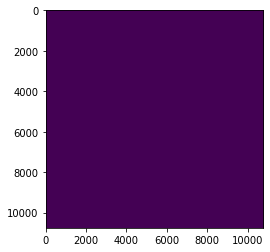

In [63]:
plt.imshow(result)

### Modeling Results

Unfortunately my computer doesn't allow me to take advantage of GPU training boosting and due to that, I had to rebuilt entire modeling process in google colabs. And because of that, I couldn't upload to google collabs all the augmentations that were created, therefore, a big amount of my work was lost (Used only 414 images out of +-5000). Our model did very badly, because of all computational-resources obstacles which have occurred during the modeling process. In order to improve results it would be reasonable to use a Jaccard Index as a loss function. Accuracy is a bad metric for imbalanced data (the one we have) and I'd replace it with IoU score (useful for image segmentation) and F1-score (useful for unbalanced dataset). The main problem here is a very poor amount of data (only 1 tile), which has very little instances of soil erosion.